# Travaux Pratiques d'imagerie par rayons X

# Exercice 1 - Loi d'atténuation
Le but est de retrouver le coefficient d’atténuation linéique à 100 keV de matériaux à travers une simulation simple mais réaliste en utilisant la loi de Beer-Lambert :
$$
N_{\mathrm{dt}}=N_0\exp(-\mu(E)X)
$$
où $N_0$ est le nombre de photons incident sur l'objet d'épaisseur $X$ et $\mu$ le coefficient d'atténuation linéique à l'énergie $E$.

## Coefficient d'atténuation linéique<a id='section_mu'></a>
$$
\mu = \sum_{i\in\mathsf{Interactions}} \mu_i = \rho \frac{\mathcal{N}_A}{A} \left(
\sum_{i\in\mathsf{Interactions}}\sigma_i\right)
$$
où $\sigma_i$, qui ne dépend pas de la densité $\rho$, est la section efficace (en cm$^2$) de l'interaction $i$ pour le materiau.

In [ ]:
%matplotlib ipympl
import matplotlib
import ipywidgets as widgets
import TPFunctions
#from importlib import reload
#reload(TPFunctions);
widgets.interact_manual(TPFunctions.mu, 
                        material = widgets.Dropdown(options=[('Polyethylene','H2C'),('Cuivre','Cu'),('Iode','I'),('Plomb','Pb'),('Aluminium','Al'),('Eau','H2O')],
                                         value="H2C",layout={'width': 'max-content'},description='Matériau :',
                                         style={'description_width': 'initial'}));

## Conditions expérimentales
Le code suivant simule un nombre de photons détectés après avoir traversé 0.1 mm de plomb (Pb, densité 11.35 g.cm$^{⁻3}$) et 3.9 cm de polyéthylène (H$_2$C, densité 0.94 g.cm$^{⁻3}$) étant donné un nombre de photons incidents. Le processus stochastique d'atténuation est reproduit (par une loi de probabilité de Poisson).

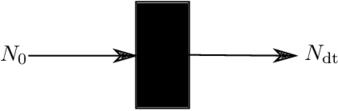


NB : le type de visualisation dépend du nombre $N_0$ de photons incidents demandés :
- jusque $N_0\leq100$ vous avez les visualisations 3D successives des deux simulations (une pour chaque matériau), 
- entre $100<N_0\leq10000$ vous avez les distributions en énergie des photons qui sortent du matériau.

## Travail demandé 1.1

Nous allons calculer le coefficient d'atténuation du plomb et du polyéthylène à 100 keV avec une précision donnée. Il vous faudra adapter le nombre de photons envoyés. Pour mémoire, la loi de propagation d'erreur d'une fonction $y(x_1, ..., x_N)$ est
$$
\mathrm{Var}[y]=\sum_{i=1}^N\left(\dfrac{\partial y}{\partial x_i}\right)^2\mathrm{Var}[x_i]
$$
où la variance $\mathrm{Var}[]$ représente le carré de l'écart-type $\sigma$ (i.e.~l'erreur). Pour ce faire : 
1. Lancez une première simulation avec un nombre arbitraire de photons $N_0$.
3. Trouvez l'expression l'erreur relative $\sigma[\mu]/\mu$ en fonction de $N_{0}$ et $\mu X$, et calculez cette erreur relative pour cette première simulation.
2. Calculez le nombre de photons $N_0^*$ nécessaire pour amener cette erreur relative à $10^{-3}$.
3. Lancez une deuxième simulation avec ce nombre de photons $N_0^*$.
4. Vérifiez la concordance du résultat obtenu avec le coefficient d’atténuation linéique théorique obtenu dans la cellule [ci-dessus](#section_mu).


In [ ]:
%matplotlib ipympl
#%matplotlib notebook
import matplotlib
import ipywidgets as widgets
import TPFunctions
#from importlib import reload
#reload(TPFunctions);
widgets.interact_manual(TPFunctions.simulator,
                        N0=widgets.IntText(value=100,description="Nombre de photons émis :",disabled=False,
                                           style={'description_width': 'initial'}),
                        energy1=widgets.fixed(100),
                        energy2=widgets.fixed(100),
                        material1=widgets.fixed("H2C"),
                        thickness1=widgets.fixed(3.9),
                        material2=widgets.fixed("Pb"),
                        thickness2=widgets.fixed(0.01));

## Travail demandé 1.2
Nous souhaiterions étudier les interactions qui se produisent dans le polyéthylène et l'iode en fonction de l'énergie incidente des photons. 

Étudiez les courbes de coefficient d'atténuation linéique de ces deux matériaux que vous pouvez obtenir dans la cellule [ci-dessus](#section_mu).
Pour chacun des matériaux, trouvez la gamme d'énergie pour laquelle les interactions se produisent majoritairement par effet photoélectrique puis celle majoritairement par diffusion Compton.

Faites ensuite des simulations GATE pour en faire l'illustration en fixant l'épaisseur de matériaux permettant d'avoir une transmission de 50% des photons. Discutez les visualisations obtenues (vues 3D et distributions en énergie des photons). Vous trouverez les raies de fluorescence et leur probabilité d'émission sur le [site du LBL](https://xdb.lbl.gov/Section1/Table_1-3.pdf). Pour mémoire, l'énergie du photon diffusé Compton dépend de l'angle de diffusion $\theta$ selon la loi suivante :

$$ 
E_{\text{diffusé}} = E_{\text{incident}} \left/ \left[{1+\frac{E_{\text{incident}}}{511 \text{keV}}\left(1-\cos\left(\theta\right)\right)}\right]\right.
$$

In [1]:
%matplotlib ipympl
import matplotlib
import ipywidgets as widgets
import TPFunctions
widgets.interact_manual(TPFunctions.simulator,
                        N0=widgets.IntText(value=100,description="Nombre de photons émis :",disabled=False,
                                           style={'description_width': 'initial'}),
                        energy1=widgets.BoundedIntText(value=100,min=1,max=800,step=1,style= {'description_width': 'initial'}, description="Énergie H2C (keV)"),
                        energy2=widgets.BoundedIntText(value=100,min=1,max=800,step=1,style= {'description_width': 'initial'}, description="Énergie I (keV)"),
                        material1=widgets.fixed("H2C"),
                        thickness1=widgets.BoundedFloatText(value=1,min=0,max=800,step=1,style= {'description_width': 'initial'}, description="Épaisseur H2C (cm)"),
                        material2=widgets.fixed("I"),
                        thickness2=widgets.BoundedFloatText(value=0.1,min=0,max=800,step=1,style= {'description_width': 'initial'},description="Épaisseur I (cm)"));

interactive(children=(IntText(value=100, description='Nombre de photons émis :', style=DescriptionStyle(descri…

# Exercice 2 - Étude du polychromatisme

La largeur du spectre en énergie des photons incidents a une forte influence sur la formation de
l’image radiologique. Nous l’étudions ici.

## Conditions expérimentales

Le logiciel de simulation ci-dessous permet de calculer des spectres tels que générés par les générateurs de rayons X en précisant :
- la haute tension U d’accélération des électrons,
- l'épaisseur et la nature d'une plaque insérée dans le faisceau.

Certaines grandeurs associées aux spectres sont calculées en sortie notamment
- la couche de demi-atténuation (en mm d’Al),
- l’énergie moyenne des photons du spectre.

Nota Bene : caractéristiques du tube X
- réglé pour avoir 1 mGy à 1 m dans l'air en absence objet,
- filtration interne de 1.2 mm d'aluminium.


## Travail demandé

Nous allons observer l’évolution du spectre en fonction de l’épaisseur et de la nature d'une plaque insérée dans le faisceau. Utilisez les widgets pour sélectionner le matériau et l'épaisseur de la plaque.
- Tracez l'énergie moyenne des photons transmis derrière une plaque en fonction de son épaisseur pour des plaques en cuivre puis en plomb pour une tension de 100 kV. Quelles sont les valeurs limites ?
- Expliquez la différence entre les deux spectres transmis (plomb vs cuivre) en regardant les coefficients d'atténuation correspondants, disponibles dans la cellule [ci-dessus](#section_mu).
- Déterminez pour ce spectre de rayons X de 100 kV les 10 premières HVL (couches de demi-atténuation) exprimées en mm d'aluminium. Expliquez la valeur limite.
- Pour l'ensemble des matériaux proposés dans le menu déroulant, trouvez l'épaisseur de plaque correspondante qui supprime les énergies en dessous de 40 keV. Expliquez les différences. Vérifiez que ce filtre fonctionne également pour d'autres tensions.

In [ ]:
%matplotlib ipympl
import matplotlib
import ipywidgets as widgets
import TPFunctions
widgets.interact_manual(TPFunctions.spectrum, 
                E0 = widgets.IntText(value=100,step=1,description="Haute tension (kV) :",disabled=False,
                                     style={'description_width': 'initial'}),
                Mat_Z = widgets.Dropdown(options=[('eau',"Water, Liquid"),('aluminium',"Al"),('cuivre',"Cu"),('plomb',"Pb")],
                                         value="Water, Liquid",layout={'width': 'max-content'},description='Matériau :',
                                         style={'description_width': 'initial'}),
                Mat_X = widgets.FloatText(value=0.,step=0.01,description="Épaisseur (mm) :",disabled=False,
                                          style={'description_width': 'initial'}));


# Exercice 3 - Étude du diffusé - Données expérimentales


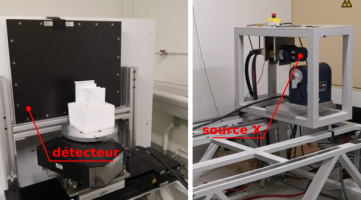

Nous avons fait 3 acquisitions avec une source réglée sur 100 kV en tension et 3 mA en courant et un détecteur Varian de 2048 par 1536 pixels de 194 microns. Pour simplifier, nous considérerons que la mesure codée sur 2 octets en chaque pixel fournie par le détecteur est proportionnelle au nombre de photons incidents sur ce pixel. Nous avons pris comme objet quatre plaques de polyéthylène de 5 mm d'épaisseur et arrangées de telle sorte à faire 2 marches de 1 et 2 cm d'épaisseur. Les trois acquisitions sont les suivantes :

1. une image sans objet appelée "Référence 100 kV 3 mA",
2. une image avec les plaques placées contre le détecteur,
3. une image avec les plaques placées à 75 cm du détecteur.

Les acquisitions et des profils horizontaux extraits des images sont présentés ci-dessous. 

In [ ]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

gradinPEclose = io.imread('images/ImagePEclose.jpg')
plt.close(6)
plt.figure(num=6,figsize=(3,2), dpi=150, clear=True)
plt.subplot(111)
plt.imshow(gradinPEclose)
plt.title('Contre le détecteur', fontsize=8)
plt.axis('off')

xc1 = 400
xc2 = 1600
yc = 1040
xf1 = 300
xf2 = 1950
yf = 696

kVmA = io.imread('images/kV100mA3.tif')
PEclose = io.imread('images/PE0cm_kV100mA3.tif')
PEfar = io.imread('images/PE75cm_kV100mA3.tif')
plt.close(7)
plt.figure(num=7,figsize=(6,2), dpi=150)
plt.subplot(121)
plt.imshow(kVmA, cmap=plt.cm.gray)
plt.title('Référence 100kV 3mA', fontsize=8)
plt.plot([xc1, xc2], [yc, yc], 'r-', lw=1)
plt.subplot(122)
plt.imshow(PEclose, cmap=plt.cm.gray)
plt.title('Contre le détecteur', fontsize=8)
plt.plot([xc1, xc2], [yc, yc], 'r-', lw=1)

plt.close(8)
plt.figure(num=8, figsize=(6,2), dpi=150)
plt.subplot(121)
plt.plot(kVmA[yc,xc1:xc2])
plt.title('Référence 100kV 3mA', fontsize=8)
plt.subplot(122)
plt.plot(PEclose[yc,xc1:xc2])
plt.title('Contre le détecteur', fontsize=8)

gradinPEfar = io.imread('images/ImagePEfar.jpg')
plt.close(9)
plt.figure(num=9, figsize=(3,2), dpi=150)
plt.subplot(111)
plt.imshow(gradinPEfar)
plt.title('À 75cm du détecteur', fontsize=8)
plt.axis('off')

plt.close(10)
plt.figure(num=10, figsize=(6,2), dpi=150)
plt.subplot(121)
plt.imshow(kVmA, cmap=plt.cm.gray)
plt.title('Référence', fontsize=8)
plt.plot([xf1, xf2], [yf, yf], 'r-', lw=1)
plt.subplot(122)
plt.imshow(PEfar, cmap=plt.cm.gray)
plt.title('À 75cm du détecteur', fontsize=8)
plt.plot([xf1, xf2], [yf, yf], 'r-', lw=1)

plt.close(11)
plt.figure(num=11,figsize=(6,2), dpi=150)
plt.subplot(121)
plt.plot(kVmA[yf,xf1:xf2])
plt.title('Référence 100kV 3mA', fontsize=8)
plt.subplot(122)
plt.plot(PEfar[yf,xf1:xf2])
plt.title('À 75cm du détecteur', fontsize=8)

plt.show()

## Travail demandé

- Calculez la distance source-détecteur.
- On définit le SPR en un pixel donné du détecteur comme le rapport entre le nombre de photons issus d'interactions avec les plaques de polyéthylène (PE) sur le nombre de photons directement transmis sans interaction à travers les plaques. Donnez l'intervalle de variation du SPR sur 3 régions : celle de l'air, celle de 1 cm de PE et celle de 2cm de PE.

## Simulation

Pour appuyer vos explications, la cellule suivante simule approximativement la même scène avec une collimation de la source limitée à un tiers dans dans la direction verticale.

In [ ]:
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import TPFunctions
#from importlib import reload
#reload(TPFunctions);

widgets.interact_manual(TPFunctions.simulator_scatter,
                        N0=widgets.IntText(value=100,description="Nombre de photons émis :",disabled=False,
                                           style={'description_width': 'initial'}),
                        position=widgets.IntText(value=50,description="Distance détecteur objet (cm) :",disabled=False,
                                           style={'description_width': 'initial'}),
                        sdd=widgets.IntText(value=100,description="Distance source détecteur (cm) :",disabled=False,
                                           style={'description_width': 'initial'}));